# Table of Contents

#### 1. Import Libraries and Data
#### 2. Data Aggregation and Wrangling for Time-Series Data
#### 3. Line Chart of Passenger Counts by GEO Region
#### 4. Time-Series Analysis: Decomposition
#### 5. Dickey-Fuller Test for Stationarity
- Result Interpretation
#### 6. Differencing and Re-Testing for Stationarity
#### 7. Autocorrelation Analysis
#### 8. Proposal of Future Analytics Pipeline

### Import Libraries and Data

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
df = pd.read_csv('/Users/bonnie/Desktop/A New Career/CareerFoundry/Data Immersion/A6_Dashboard/Air_Traffic_Analysis/02 Data/Prepared Data/Air_Traffic_Pax_v3.csv')

### 2. Data Aggregation and Wrangling for Time-Series Data

In [3]:
# Aggregate data for GEO Region
df_grouped = df.groupby(['Year', 'Month', 'GEO Region'])['Passenger Count'].sum().reset_index()

In [5]:
# Check result
df_grouped.head()

,Year,Month,GEO Region,Passenger Count
0,2006,April,Asia,908056
1,2006,April,Australia / Oceania,34982
2,2006,April,Canada,90916
3,2006,April,Central America,8936
4,2006,April,Europe,188428


In [6]:
# Create a date column and set it as index
df_grouped['Date'] = pd.to_datetime(df_grouped['Year'].astype(str) + '-' + df_grouped['Month'] + '-01')
df_grouped = df_grouped.set_index('Date').sort_index()

# Check result
df_grouped.head()

,Year,Month,GEO Region,Passenger Count
Date,,,,
2006-01-01,2006,January,US,1797450
2006-01-01,2006,January,Mexico,65369
2006-01-01,2006,January,Europe,152097
2006-01-01,2006,January,Central America,11558
2006-01-01,2006,January,Canada,75681


In [7]:
# Pivot the table to have each GEO Region as a column for easier plotting and decomposition
df_pivot = df_grouped.pivot_table(index='Date', columns='GEO Region', values='Passenger Count')
df_pivot.head()

GEO Region,Asia,Australia / Oceania,Canada,Central America,Europe,Mexico,Middle East,South America,US
Date,,,,,,,,,
2006-01-01,986344.0,36438.0,75681.0,11558.0,152097.0,65369.0,NaN,NaN,1797450.0
2006-02-01,806794.0,29059.0,75953.0,8114.0,125598.0,58797.0,NaN,NaN,1674224.0
2006-03-01,882789.0,32297.0,91996.0,8831.0,167914.0,66895.0,NaN,NaN,2047021.0
2006-04-01,908056.0,34982.0,90916.0,8936.0,188428.0,70912.0,NaN,NaN,2083229.0
2006-05-01,984548.0,31516.0,98411.0,8854.0,197401.0,54840.0,NaN,NaN,2114326.0


>**Unnecessary for subsetting the data:**<br/>
The dataset spans from January 2006 to December 2015. This period precedes significant historical events that could bias a time-series analysis of air traffic, such as the COVID-19 pandemic. Therefore, no subsetting of the data was necessary, as the entire historical domain is relevant and there are no irrelevant historical events. The data does not appear to contain any forecasted values.

### 3. Line Chart of Passenger Counts by GEO Region

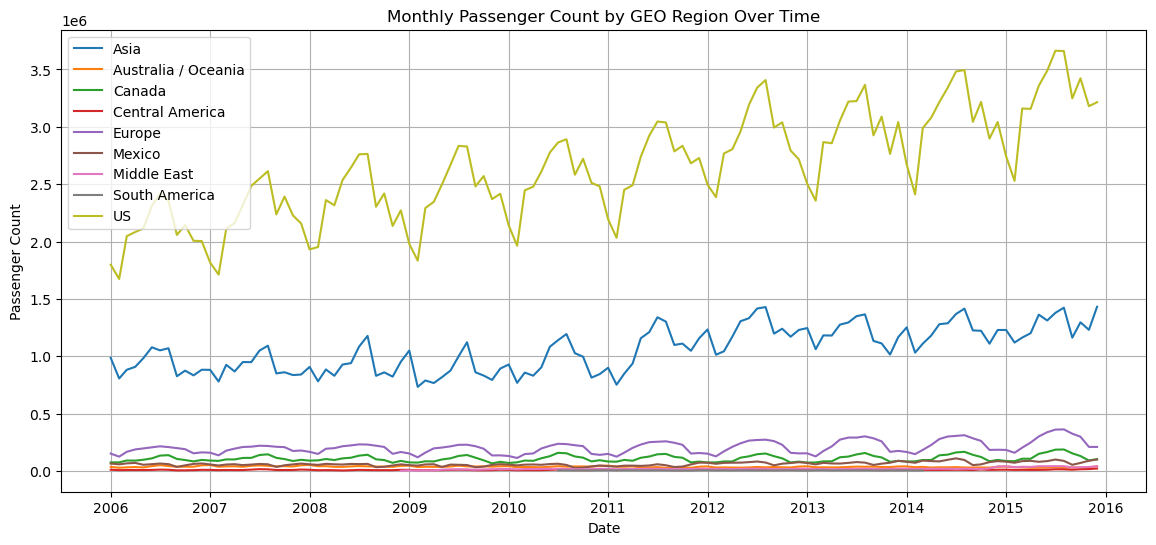

<Figure size 640x480 with 0 Axes>

In [9]:
# Create a line chart ---
plt.figure(figsize=(14, 6))
for region in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[region], label=region)

# Setting up the format
plt.title('Monthly Passenger Count by GEO Region Over Time')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('passenger_count_by_region_line_chart.png')

>**Observation:** <br/>
It's clear from the plot that all regions exhibit a consistent seasonal pattern with peaks and troughs occurring annually. A strong upward trend is also visible in most regions, indicating a general increase in air travel over this decade.

### 4. Time-Series Analysis: Decomposition

In [12]:
# Decompose the data
us_series = df_pivot['US'].dropna() # Choosing the 'US' region for decomposition as it has the most data.
us_series

Date
2006-01-01    1797450.0
2006-02-01    1674224.0
2006-03-01    2047021.0
2006-04-01    2083229.0
2006-05-01    2114326.0
                ...    
2015-08-01    3660313.0
2015-09-01    3248068.0
2015-10-01    3422573.0
2015-11-01    3179364.0
2015-12-01    3214685.0
Name: US, Length: 120, dtype: float64

In [11]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(us_series, model='additive', period=12) # monthly data, so period is 12

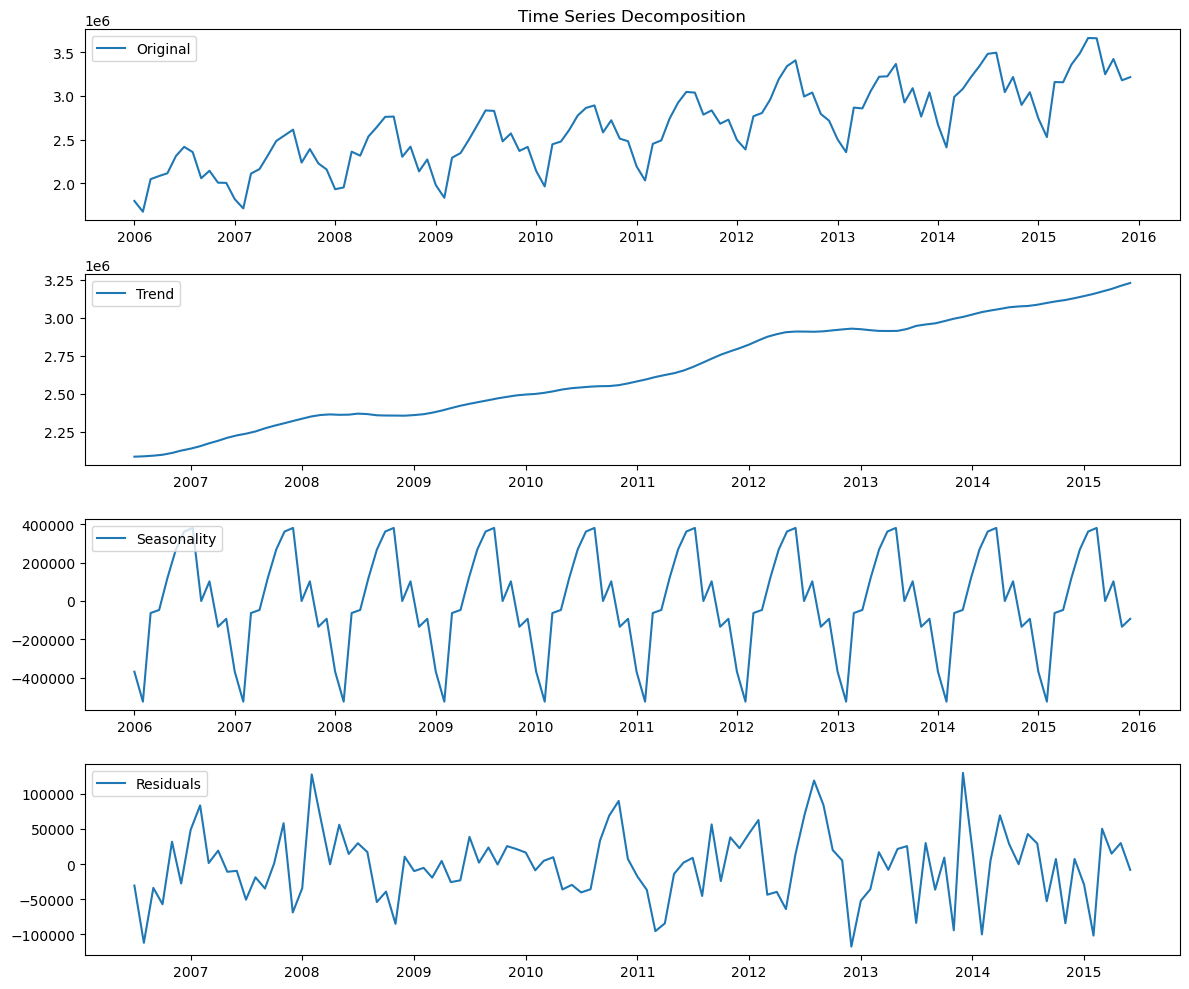

<Figure size 640x480 with 0 Axes>

In [14]:
# Plot the decomposed components
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Original')

# Setting up formats
plt.legend(loc='upper left')
plt.title('Time Series Decomposition')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
plt.savefig('us_passenger_count_decomposition.png')

>To further analyze the components of the time series, the data for the 'US' region was decomposed into its trend, seasonality, and residual components. The decomposition plot above shows:
>- **Trend:** The trend component shows a clear upward trajectory, confirming the overall growth in domestic air travel over the 10-year period.
>- **Seasonality:** The seasonal component reveals a distinct yearly pattern, with passenger counts consistently peaking during the summer months and dropping in the winter. This is a characteristic of air travel data.
>- **Residuals:** The residual plot shows the remaining noise after the trend and seasonality have been removed. The residuals appear random, which is desirable as it indicates that the model has effectively captured the primary patterns in the data.

### 5. Dickey-Fuller Test for Stationarity

In [16]:
# Define the dickey_fuller function as requested
def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the 'US' time series
dickey_fuller(us_series)

Dickey-Fuller Stationarity test:
Test Statistic                  -0.218777
p-value                          0.936246
Number of Lags Used             13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


>**Result Interpretation:**

>- Null Hypothesis (H_0): The time series is non-stationary and has a unit root.
>- Test Result: The p-value was approximately 0.9362.
Since the p-value is much greater than the significance level of 0.05, we fail to reject the null hypothesis. This confirms that the original time series is non-stationary, which is consistent with the visible trend in the line chart.


### 6. Differencing and Re-Testing for Stationarity

In [18]:
# Create the differenced series
us_series_diff = us_series.diff().dropna()

In [19]:
# Apply the test using the function on the differenced time series
dickey_fuller(us_series_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.299794
p-value                          0.014888
Number of Lags Used             12.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


>**Note:**<br/>
>The p-value of approximately 0.015 is less than the 0.05 significance level, which indicates that we reject the null hypothesis. This confirms that the differenced time series is stationary.

### 7. Autocorrelation Analysis

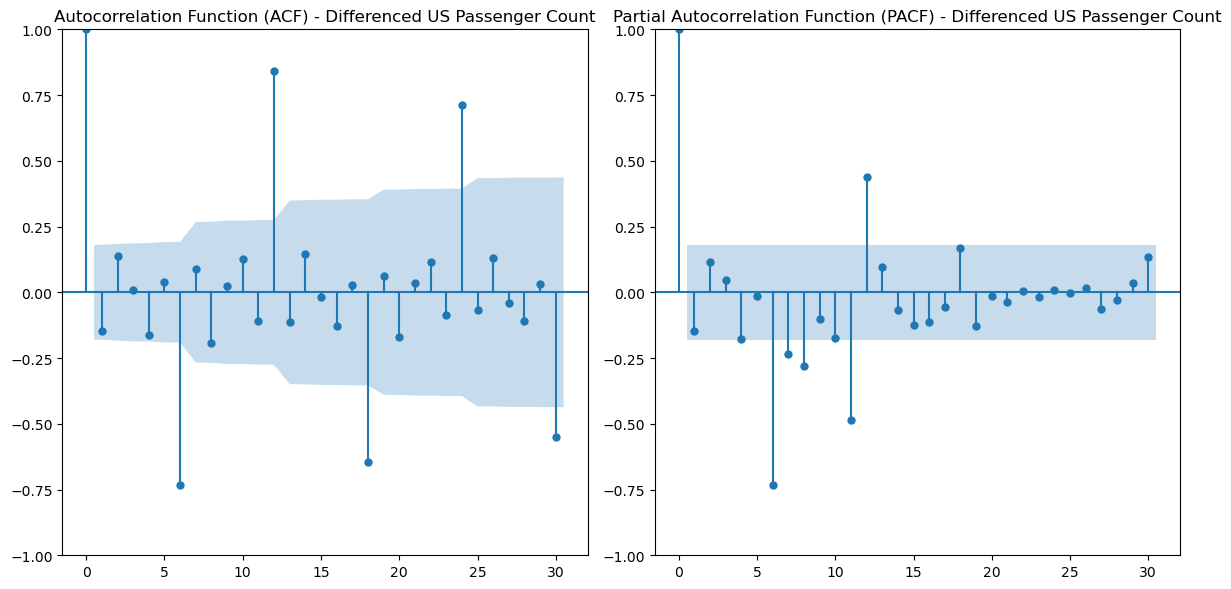

<Figure size 640x480 with 0 Axes>

In [20]:
# Plot ACF and PACF for the differenced (stationary) series
plt.figure(figsize=(12, 6))
plot_acf(us_series_diff, lags=30, title='Autocorrelation Function (ACF) - Differenced US Passenger Count', ax=plt.subplot(121))
plot_pacf(us_series_diff, lags=30, title='Partial Autocorrelation Function (PACF) - Differenced US Passenger Count', ax=plt.subplot(122))
plt.tight_layout()
plt.show()
plt.savefig('us_passenger_count_acf_pacf.png')

>The **ACF** and **PACF** plots above show the correlation of the series with its lagged values.
> - **ACF** Plot: The ACF plot shows a significant spike at lag 1, indicating a strong negative correlation with the previous month's value, which is typical for differenced series. The spikes at lags 12, 24, and 36 suggest remaining seasonality even after a single round of differencing.
> - **PACF** Plot: The PACF plot also shows significant spikes at lags 1, 12, and other multiples of 12. This suggests that the passenger count in a given month is directly influenced by the count in the same month of the previous year.
> 
> The **ACF** and **PACF** plots for the differenced time series help in identifying the order of the AR (p) and MA (q) terms for an ARIMA model.

### 8. Proposal of Future Analytics Pipeline

_In terms of the proposal of future analytics pipeline, it could be broken down to three phases shown below:_

>**Phase 1: Advanced Modeling and Forecasting** <br/>
>_After getting a stationary time series, the next logical step is to build a predictive model_
> - **Model Building:** Construct a Seasonal ARIMA (SARIMA) model. The ACF and PACF plots from your analysis will be crucial for determining the p, q, P, and Q parameters. The seasonal component is particularly important given the clear yearly pattern observed in the data. You could also explore other models like Prophet, developed by Facebook, which is designed to handle seasonality and holidays automatically.
> - **Forecasting:** Once a robust model is built, you can use it to forecast future passenger counts. This would be invaluable for capacity planning, resource allocation, and revenue projections.

>**Phase 2: Expanded Data Sourcing and Integration**<br/>
>_To enrich the analysis and improve models, the dataset should be expanded by integrating new data sources._
> - **Macroeconomic Data:** Incorporate additional economic indicators beyond GDP, such as inflation rates, consumer spending, and fuel prices. These could be used as exogenous variables in your forecasting models.
> - **Competitor and Route-Specific Data:** If available, adding data on competitor airlines, new routes, and specific events in different geographic regions would provide a more granular understanding of traffic patterns.

>**Phase 3: Machine Learning**<br/>
>_Beyond traditional time-series models, the advanced machine learning techniques could be applied to uncover deeper insights._
> - **The Combined Pipeline for Machine Learning Models:** Combining a Random Forest model with K-means is a powerful approach that integrates unsupervised and supervised learning to improve predictive performance. This two-step process allows the predictive model to leverage insights from the data's underlying structure.<br/>

> _**This approach is beneficial because K-means can uncover hidden relationships in the data, providing a valuable engineered feature that can significantly boost the predictive power of the Random Forest model.**_